# **Importing all the required packages**

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
import pickle
from google.colab import drive

# **Loading the dataset**

In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/kalimati_market.csv'
df = pd.read_csv(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Display initial data info
print('Data Info BEFORE Cleaning:')
print(df.info())
print('\nShape:', df.shape)

Data Info BEFORE Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96479 entries, 0 to 96478
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tomato Big(Nepali)  96479 non-null  object
 1   1/5/2021            96479 non-null  object
 2   Kg                  96479 non-null  object
 3   50                  96479 non-null  object
 4   60                  96479 non-null  object
 5   55                  96479 non-null  object
dtypes: object(6)
memory usage: 4.4+ MB
None

Shape: (96479, 6)


# **Data Cleaning**

In [ ]:
# Renaming columns
df.columns = ['Vegetable', 'Date', 'Unit', 'Minimum', 'Maximum', 'Average']

In [ ]:
# Cleaning price columns
for col in ['Minimum', 'Maximum', 'Average']:
    df[col] = df[col].astype(str).str.replace('Rs', '', regex=False).str.replace('.00', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Converting Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


# Dropping invalid rows
df = df[(df['Minimum'] > 0) & (df['Maximum'] > 0) & (df['Average'] > 0)]
df = df.dropna(subset=['Vegetable', 'Date', 'Average']).drop_duplicates()

print('\nData Info AFTER Cleaning:')
print(df.info())
print('\nShape:', df.shape)



Data Info AFTER Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 45323 entries, 0 to 45322
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Vegetable  45323 non-null  object        
 1   Date       45323 non-null  datetime64[ns]
 2   Unit       45323 non-null  object        
 3   Minimum    45323 non-null  float64       
 4   Maximum    45323 non-null  float64       
 5   Average    45323 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 2.4+ MB
None

Shape: (45323, 6)


In [ ]:
mean_value = df['Average'].mean()
std_dev = df['Average'].std()

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_dev}")

Mean: 123.0844935242592
Standard Deviation: 127.60653712478889


# **Checking for Possible Outliers**

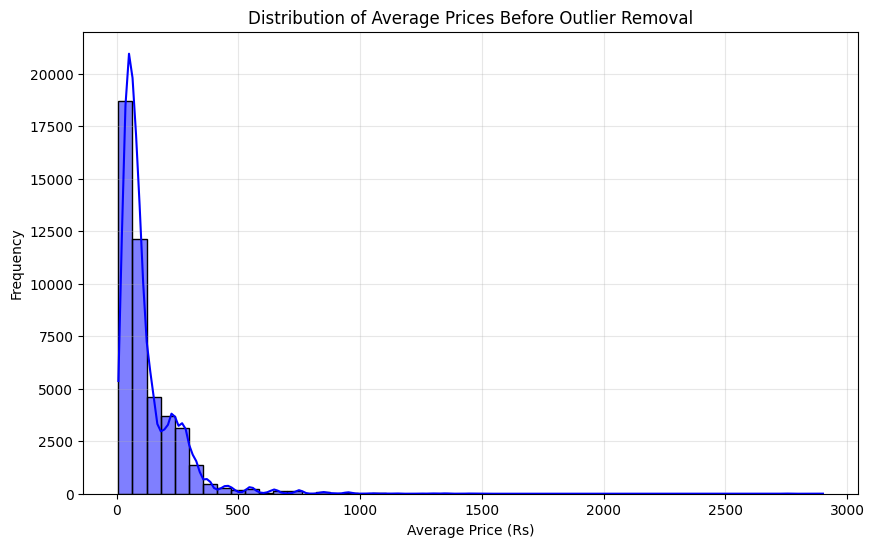

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Average'], kde=True, color='blue', bins=50)
plt.title('Distribution of Average Prices Before Outlier Removal')
plt.xlabel('Average Price (Rs)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

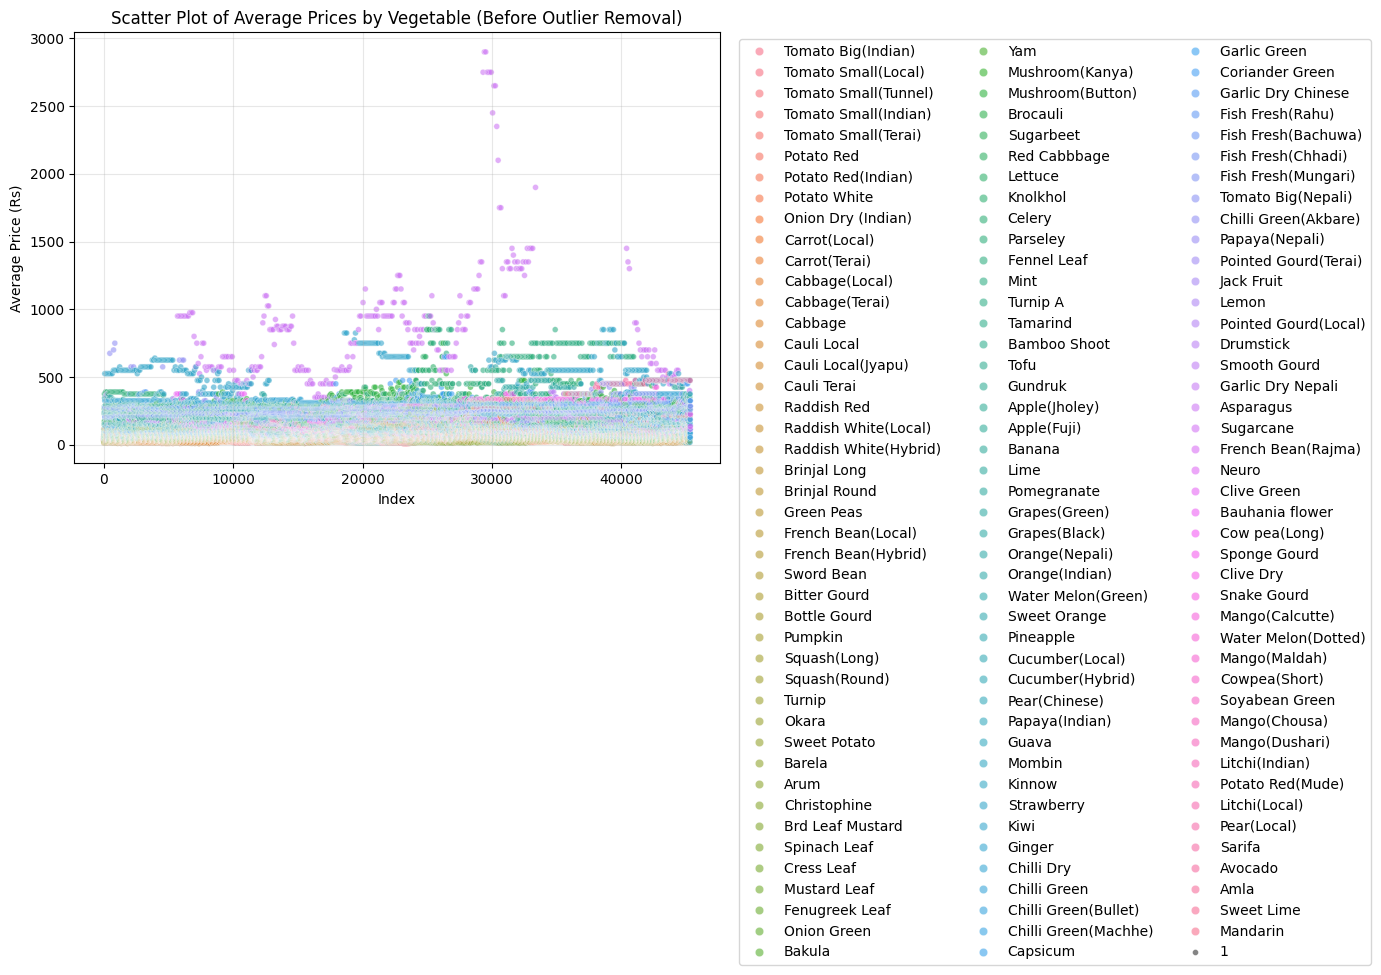

In [ ]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x=df.index, y=df['Average'], hue=df['Vegetable'], size=1, alpha=0.6)
plt.title('Scatter Plot of Average Prices by Vegetable (Before Outlier Removal)')
plt.xlabel('Index')
plt.ylabel('Average Price (Rs)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**we can see through the histogram and scatterplot that there certainly are some outliers in our dataset that ranges to up to around 3000rs Average Price.**

# **Removing Outliers**

In [ ]:
# Outlier Removal
def detect_and_remove_outliers(df, column='Average', iqr_multiplier=1.5, z_score_threshold=2.17):
    df = df.copy()
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_lower_bound = Q1 - iqr_multiplier * IQR
    iqr_upper_bound = Q3 + iqr_multiplier * IQR
    iqr_outliers = df[(df[column] < iqr_lower_bound) | (df[column] > iqr_upper_bound)]

    z_scores = (df[column] - df[column].mean()) / df[column].std()
    z_outliers = df[abs(z_scores) > z_score_threshold]

    outlier_indices = set(iqr_outliers.index).union(set(z_outliers.index))
    clean_df = df.drop(index=outlier_indices)
    print(f'Outliers removed: {len(outlier_indices)}')
    return clean_df

df = detect_and_remove_outliers(df, column='Average')
print('Remaining rows:', df.shape[0])

Outliers removed: 2448
Remaining rows: 42875


# **Checking the average prices after applying Outlier Detection**

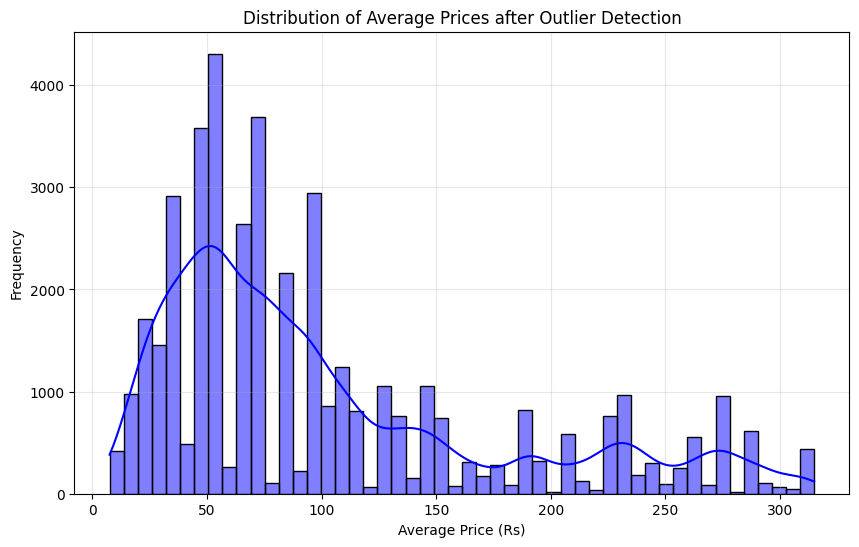

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Average'], kde=True, color='blue', bins=50)
plt.title('Distribution of Average Prices after Outlier Detection')
plt.xlabel('Average Price (Rs)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

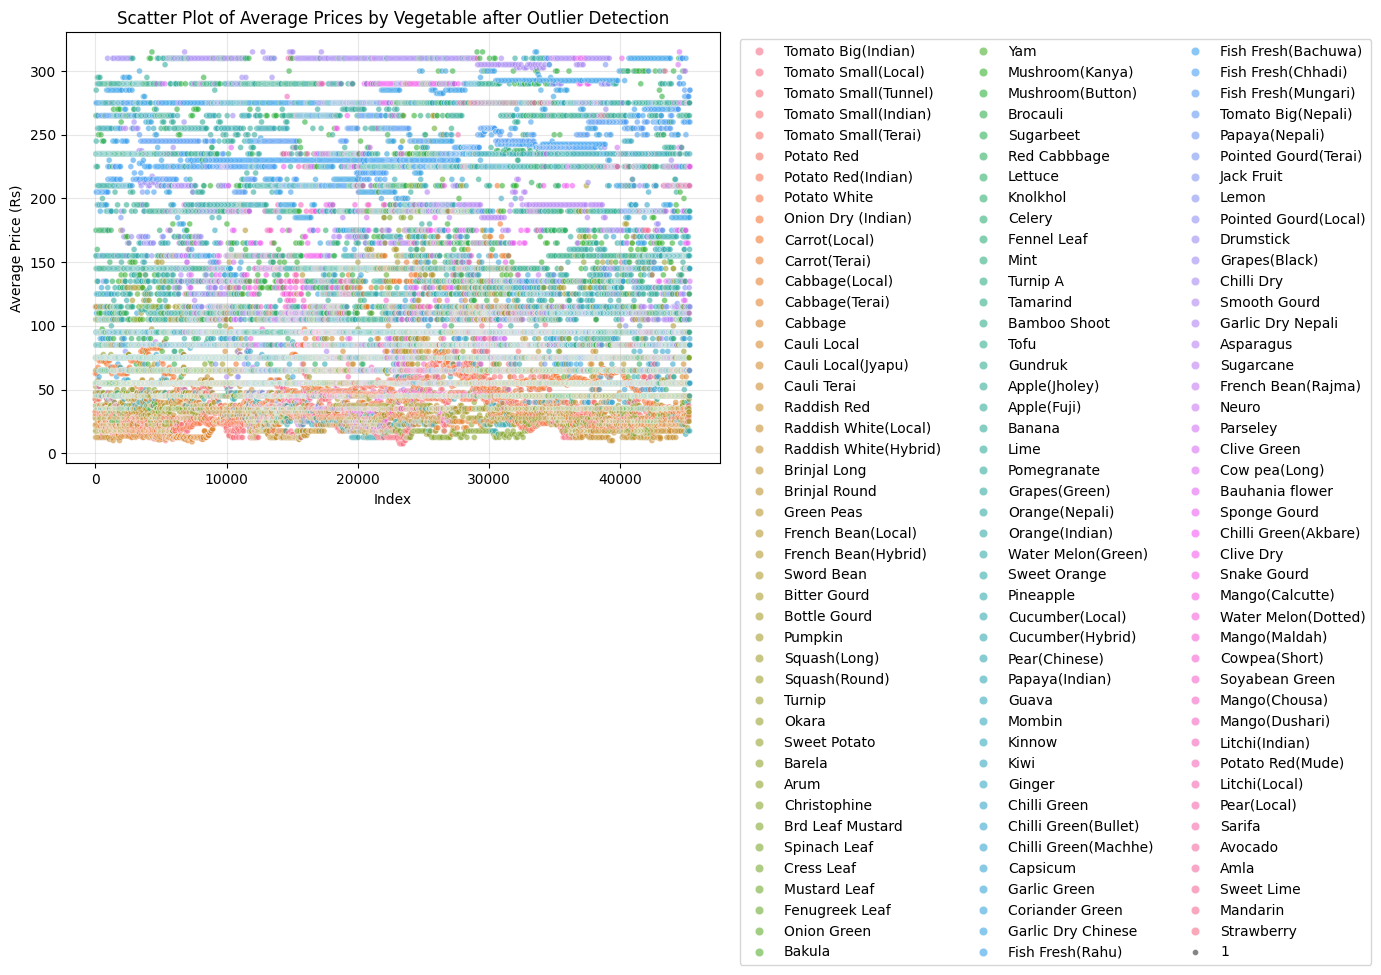

In [ ]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x=df.index, y=df['Average'], hue=df['Vegetable'], size=1, alpha=0.6)
plt.title('Scatter Plot of Average Prices by Vegetable after Outlier Detection')
plt.xlabel('Index')
plt.ylabel('Average Price (Rs)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Now we can see in the above visualizations that the outliers have been removed.**

# **Feature Engineering**

In [ ]:
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([4, 5]).astype(int)

# Extracting date parts
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Defining season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)


# **Creating Lag and Rolling Average Features for Each Vegetable's Average Price**

In [ ]:
df = df.sort_values(['Vegetable', 'Date'])

df['Average_Lag1'] = df.groupby('Vegetable')['Average'].shift(1)
df['Average_Rolling7'] = df.groupby('Vegetable')['Average'].shift(1).rolling(window=7).mean()

df = df.dropna(subset=['Average_Lag1', 'Average_Rolling7'])

# **Encoding categorical features**

In [ ]:
label_encoder_veg = LabelEncoder()
df.loc[:,'VegetableEncoded'] = label_encoder_veg.fit_transform(df['Vegetable'])

label_encoder_season = LabelEncoder()
df.loc[:,'SeasonEncoded'] = label_encoder_season.fit_transform(df['Season'])

label_encoder_veg_cls = LabelEncoder()
df.loc[:,'VegetableEncoded_cls'] = label_encoder_veg_cls.fit_transform(df['Vegetable'])

label_encoder_season_cls = LabelEncoder()
df.loc[:,'SeasonEncoded_cls'] = label_encoder_season_cls.fit_transform(df['Season'])

In [ ]:
# Saving encoders
with open('label_encoder_vegetable.pkl', 'wb') as f:
    pickle.dump(label_encoder_veg, f)
with open('label_encoder_season.pkl', 'wb') as f:
    pickle.dump(label_encoder_season, f)
print('Encoders saved successfully!')

with open('label_encoder_vegetable_cls.pkl', 'wb') as f:
    pickle.dump(label_encoder_veg_cls, f)

with open('label_encoder_season_cls.pkl', 'wb') as f:
    pickle.dump(label_encoder_season_cls, f)
print("Classification encoders saved successfully!")

Encoders saved successfully!
Classification encoders saved successfully!


# **Exploratory Data Analysis**

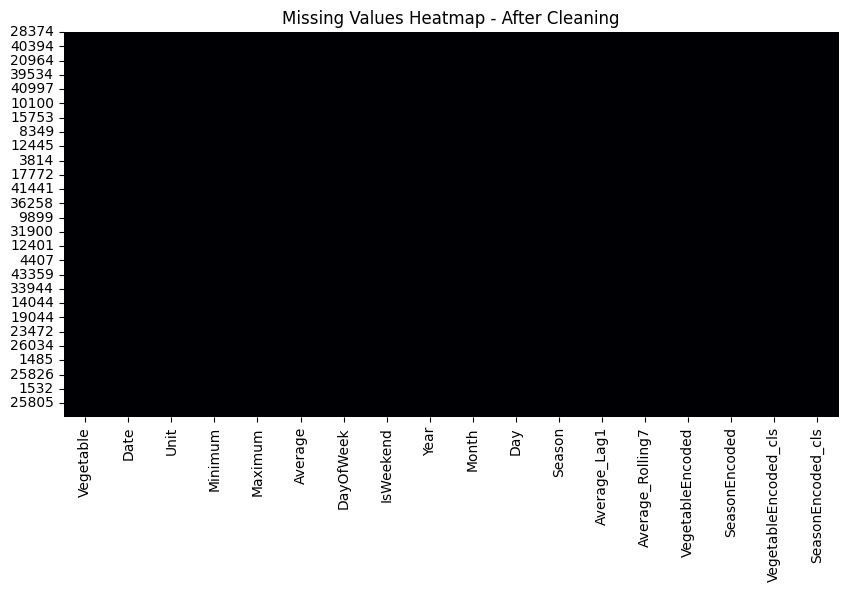

In [ ]:
# Missing values heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='magma')
plt.title('Missing Values Heatmap - After Cleaning')
plt.show()

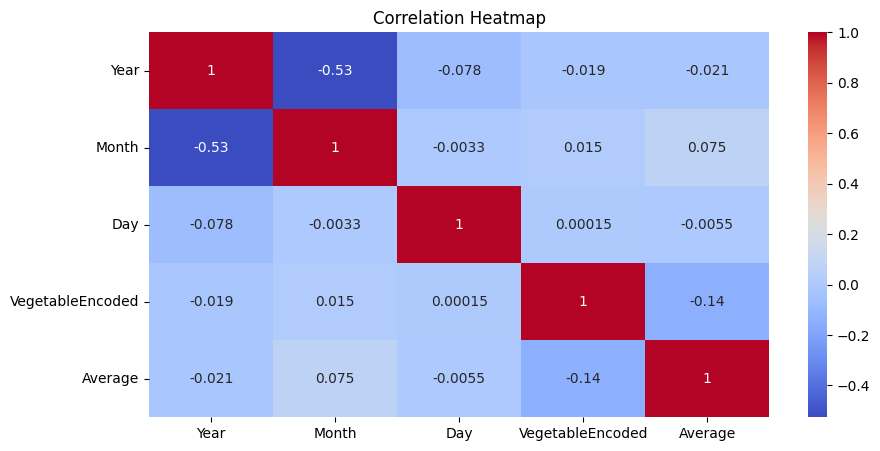

In [ ]:
# Correlation heatmap (excluding Minimum/Maximum for regression)
plt.figure(figsize=(10,5))
sns.heatmap(df[['Year', 'Month', 'Day', 'VegetableEncoded', 'Average']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

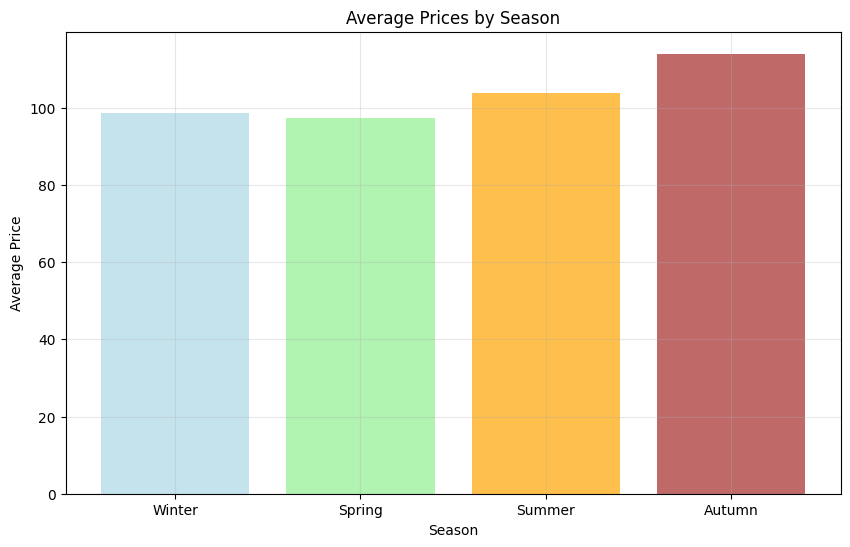

In [ ]:
# Average price by season
plt.figure(figsize=(10,6))
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
season_means = [df[df['Season'] == season]['Average'].mean() for season in seasons]
plt.bar(seasons, season_means, color=['lightblue', 'lightgreen', 'orange', 'brown'], alpha=0.7)
plt.xlabel('Season')
plt.ylabel('Average Price')
plt.title('Average Prices by Season')
plt.grid(True, alpha=0.3)
plt.show()

# **Regression Model: Random Forest**

In [ ]:
# Preparing data
X_reg = df[['VegetableEncoded', 'Year', 'Month', 'Day', 'SeasonEncoded',
            'DayOfWeek', 'IsWeekend', 'Average_Lag1', 'Average_Rolling7']]
y_reg = df['Average']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

y_train range: 7.5 315.0
y_test range: 7.5 315.0


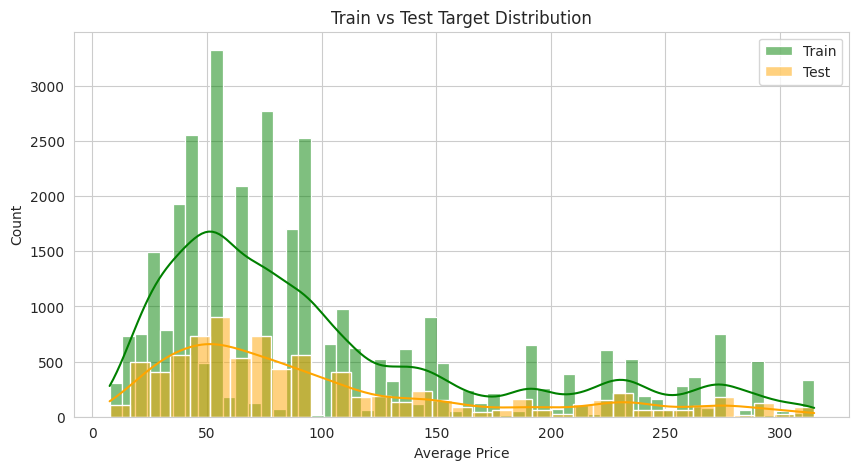

In [ ]:
# Check target distribution to diagnose mismatch
print('y_train range:', y_train.min(), y_train.max())
print('y_test range:', y_test.min(), y_test.max())

plt.figure(figsize=(10,5))
sns.histplot(y_train, kde=True, color='green', label='Train')
sns.histplot(y_test, kde=True, color='orange', label='Test')
plt.title('Train vs Test Target Distribution')
plt.xlabel('Average Price')
plt.legend()
plt.show()


# **K-Fold Cross Validation**

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5, max_features='sqrt', random_state=42, n_jobs=-1)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

for train_idx, val_idx in kfold.split(X_reg):
    X_train_k, X_val_k = X_reg.iloc[train_idx], X_reg.iloc[val_idx]
    y_train_k, y_val_k = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

    scaler = StandardScaler()
    X_train_k_scaled = scaler.fit_transform(X_train_k)
    X_val_k_scaled = scaler.transform(X_val_k)

    rf.fit(X_train_k_scaled, y_train_k)
    y_pred_k = rf.predict(X_val_k_scaled)

    mae_scores.append(mean_absolute_error(y_val_k, y_pred_k))
    mse_scores.append(mean_squared_error(y_val_k, y_pred_k))
    rmse_scores.append(np.sqrt(mse_scores[-1]))
    r2_scores.append(r2_score(y_val_k, y_pred_k))

print('Random Forest Cross-Validation Scores:')
for i in range(len(mae_scores)):
    print(f'Fold {i+1}: MAE = {mae_scores[i]:.2f}, MSE = {mse_scores[i]:.2f}, RMSE = {rmse_scores[i]:.2f}, R² = {r2_scores[i]:.4f}')

print(f'Average MAE: {np.mean(mae_scores):.2f}')
print(f'Average MSE: {np.mean(mse_scores):.2f}')
print(f'Average RMSE: {np.mean(rmse_scores):.2f}')
print(f'Average R²: {np.mean(r2_scores):.4f}')


Random Forest Cross-Validation Scores:
Fold 1: MAE = 6.13, MSE = 137.06, RMSE = 11.71, R² = 0.9759
Fold 2: MAE = 6.33, MSE = 149.22, RMSE = 12.22, R² = 0.9735
Fold 3: MAE = 6.27, MSE = 136.22, RMSE = 11.67, R² = 0.9758
Fold 4: MAE = 6.19, MSE = 140.26, RMSE = 11.84, R² = 0.9745
Fold 5: MAE = 6.51, MSE = 150.90, RMSE = 12.28, R² = 0.9734
Average MAE: 6.29
Average MSE: 142.73
Average RMSE: 11.94
Average R²: 0.9746


# **Creating and Plotting Learning Curve for Random Forest Regressor**

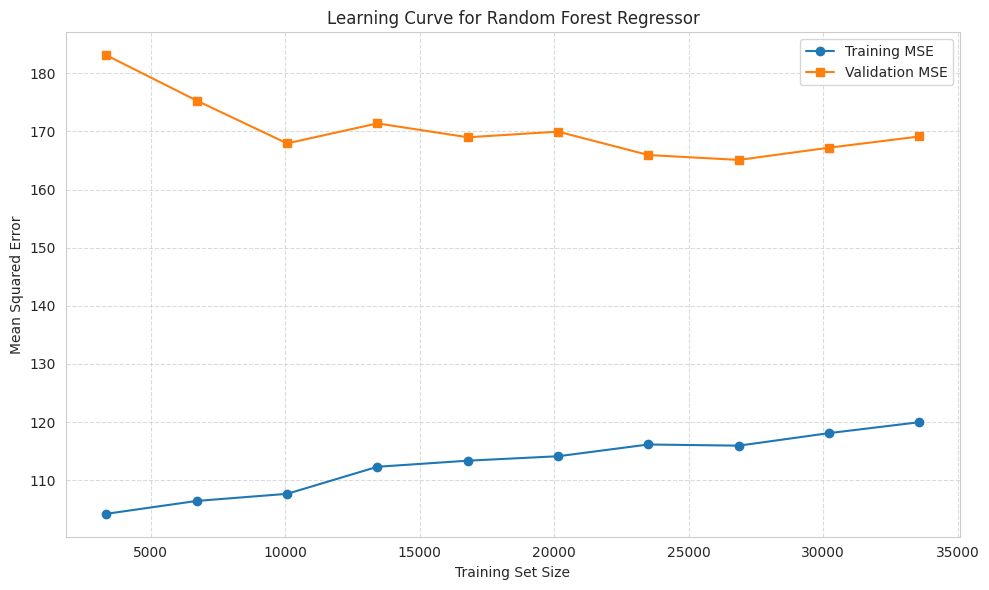

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X_reg,
    y_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Convert negative MSE to positive MSE
train_mse = -train_scores.mean(axis=1)
val_mse = -val_scores.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mse, marker='o', label='Training MSE')
plt.plot(train_sizes, val_mse, marker='s', label='Validation MSE')
plt.title('Learning Curve for Random Forest Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Training Final Random Forest Model**

In [ ]:
scaler_regression = StandardScaler()
X_train_scaled = scaler_regression.fit_transform(X_train)
X_test_scaled = scaler_regression.transform(X_test)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
y_train_pred = rf.predict(X_train_scaled)

# Save scaler and model
with open('scaler_regression.pkl', 'wb') as f:
    pickle.dump(scaler_regression, f)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

print("Final Random Forest model and scaler saved!")


Final Random Forest model and scaler saved!


In [ ]:
# Evaluation
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

print('\nRandom Forest Evaluation (Test Set):')
print(f'MAE: {mae_test:.2f}')
print(f'RMSE: {rmse_test:.2f}')
print(f'R²: {r2_test:.2f}')
print(f'MSE: {mse_test:.2f}')

print('\nRandom Forest Evaluation (Training Set):')
print(f'MAE: {mae_train:.2f}')
print(f'RMSE: {rmse_train:.2f}')
print(f'R²: {r2_train:.2f}')
print(f'MSE: {mse_train:.2f}')


Random Forest Evaluation (Test Set):
MAE: 6.13
RMSE: 11.72
R²: 0.98
MSE: 137.45

Random Forest Evaluation (Training Set):
MAE: 5.87
RMSE: 11.02
R²: 0.98
MSE: 121.44


# **EDA of Random Forest Regression**

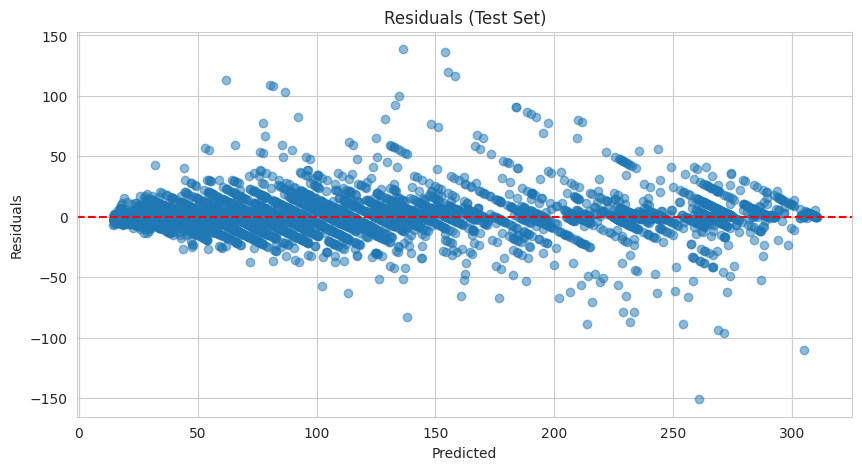

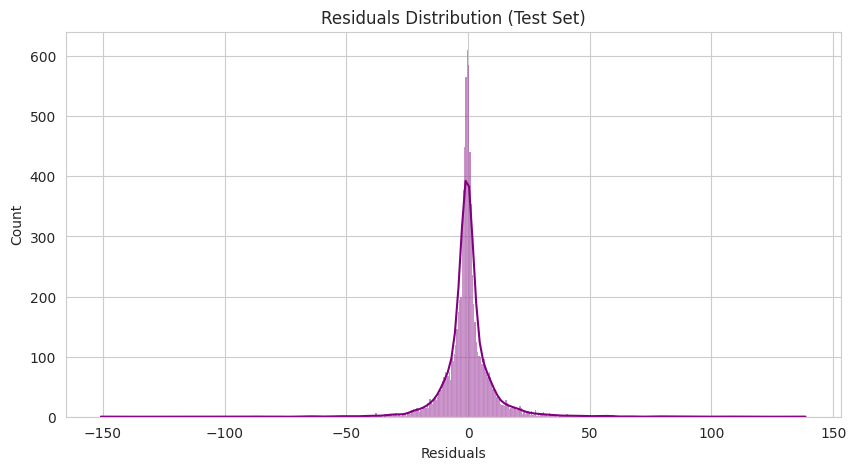

In [ ]:
# Visualizations
plt.figure(figsize=(10,5))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(y_test - y_pred, kde=True, color='purple')
plt.title('Residuals Distribution (Test Set)')
plt.xlabel('Residuals')
plt.show()


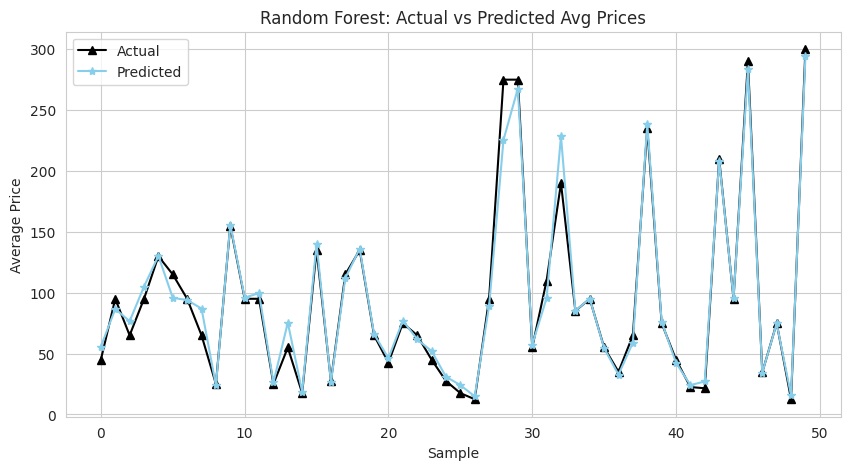

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:50], label='Actual', marker='^', color='black')
plt.plot(y_pred[:50], label='Predicted', marker='*', color='skyblue')
plt.title('Random Forest: Actual vs Predicted Avg Prices')
plt.xlabel('Sample')
plt.ylabel('Average Price')
plt.legend()
plt.grid(True)
plt.show()


# **Predicting Vegetable Price with User Selection and Date Input**

In [ ]:
def predict_price_with_selection():
    input_veg_name = input("Enter vegetable name (partial names allowed): ")

    #Finding Matches
    matches = [v for v in label_encoder_veg.classes_ if input_veg_name.lower() in v.lower()]
    if not matches:
        print(f"No vegetable matching '{input_veg_name}' found.")
        return None

    # If multiple matches, ask user to select one
    if len(matches) > 1:
        print("Multiple matches found:")
        for i, veg in enumerate(matches, 1):
            print(f"{i}. {veg}")
        choice = int(input("Enter the number of the correct vegetable: "))
        veg_name = matches[choice - 1]
    else:
        veg_name = matches[0]

    # Input date
    target_date = input("Enter date (YYYY-MM-DD): ")
    date = pd.to_datetime(target_date)
    year, month, day = date.year, date.month, date.day
    day_of_week = date.dayofweek
    is_weekend = 1 if day_of_week >= 5 else 0

    # Encoding categorical features
    veg_encoded = label_encoder_veg.transform([veg_name])[0]
    season = get_season(month)  # you should have this function
    season_encoded = label_encoder_season.transform([season])[0]

    # Retrieving historical median lag features or filling with defaults if missing
    subset = df[df['Vegetable'] == veg_name]

    avg_lag1 = subset['Average_Lag1'].median() if 'Average_Lag1' in subset.columns else 0
    avg_rolling7 = subset['Average_Rolling7'].median() if 'Average_Rolling7' in subset.columns else 0

    # Preparing feature vector (order must match training)
    features = [[
        veg_encoded, year, month, day,
        season_encoded, day_of_week, is_weekend,
        avg_lag1, avg_rolling7
    ]]

    #Scaling features
    features_scaled = scaler_regression.transform(features)

    #Predicting price using Random Forest regression model
    predicted_price = rf.predict(features_scaled)[0]

    print(f"Predicted price for 1 kg of '{veg_name}' on {target_date}: Rs {predicted_price:.2f}")
    return predicted_price
predict_price_with_selection()


Enter vegetable name (partial names allowed): potato
Multiple matches found:
1. Potato Red
2. Potato Red(Indian)
3. Potato Red(Mude)
4. Potato White
5. Sweet Potato
Enter the number of the correct vegetable: 2
Enter date (YYYY-MM-DD): 2025-09-18
Predicted price for 1 kg of 'Potato Red(Indian)' on 2025-09-18: Rs 29.03


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


np.float64(29.029853239109993)

# **Classification Model: GradientBoostingRegressor**

In [ ]:
# Categorizing average price into classes
low_threshold_cls = df['Average'].quantile(0.33)
high_threshold_cls = df['Average'].quantile(0.67)

def categorize_price_cls(price):
    if price <= low_threshold_cls:
        return 'Low'
    elif price <= high_threshold_cls:
        return 'Medium'
    else:
        return 'High'

df['PriceCategory_cls'] = df['Average'].apply(categorize_price_cls)

In [ ]:
# Encoding Target
label_encoder_target_cls = LabelEncoder()
df['PriceCategoryEncoded_cls'] = label_encoder_target_cls.fit_transform(df['PriceCategory_cls'])

with open('label_encoder_target_cls.pkl', 'wb') as f:
    pickle.dump(label_encoder_target_cls, f)

In [ ]:
# Classification Feature Set
X_cls = df[['VegetableEncoded_cls', 'Year', 'Month', 'Day', 'SeasonEncoded_cls']]
y_cls = df['PriceCategoryEncoded_cls']

In [ ]:
# Train-Test Split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

print('Train target class distribution:', np.bincount(y_train_cls))
print('Test target class distribution:', np.bincount(y_test_cls))

Train target class distribution: [11065 12403 10107]
Test target class distribution: [2766 3101 2527]


# **Cross Validation**

In [ ]:
# Model and Cross validation
scaler_cls = StandardScaler()
gb_cls = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
mse_scores_cls = []

for fold, (train_index, val_index) in enumerate(skf.split(X_cls, y_cls), 1):
    X_train_k = X_cls.iloc[train_index]
    y_train_k = y_cls.iloc[train_index]
    X_val_k = X_cls.iloc[val_index]
    y_val_k = y_cls.iloc[val_index]

    scaler_k = StandardScaler()
    X_train_k_scaled = scaler_k.fit_transform(X_train_k)
    X_val_k_scaled = scaler_k.transform(X_val_k)

    gb_cls.fit(X_train_k_scaled, y_train_k)
    y_pred_k = gb_cls.predict(X_val_k_scaled)

    acc = accuracy_score(y_val_k, y_pred_k)
    mse = mean_squared_error(y_val_k, y_pred_k)

    accuracies.append(acc)
    mse_scores_cls.append(mse)

    print(f"\nFold {fold} - Accuracy: {acc:.3f}, MSE: {mse:.3f}")
    print(classification_report(y_val_k, y_pred_k, target_names=label_encoder_target_cls.classes_))

print(f"\nAverage Accuracy: {np.mean(accuracies):.3f}")
print(f"Average MSE: {np.mean(mse_scores_cls):.3f}")


Fold 1 - Accuracy: 0.768, MSE: 0.485
              precision    recall  f1-score   support

        High       0.84      0.84      0.84      2766
         Low       0.80      0.81      0.80      3101
      Medium       0.66      0.64      0.65      2527

    accuracy                           0.77      8394
   macro avg       0.76      0.76      0.76      8394
weighted avg       0.77      0.77      0.77      8394


Fold 2 - Accuracy: 0.764, MSE: 0.523
              precision    recall  f1-score   support

        High       0.81      0.83      0.82      2766
         Low       0.82      0.80      0.81      3101
      Medium       0.65      0.65      0.65      2527

    accuracy                           0.76      8394
   macro avg       0.76      0.76      0.76      8394
weighted avg       0.76      0.76      0.76      8394


Fold 3 - Accuracy: 0.758, MSE: 0.517
              precision    recall  f1-score   support

        High       0.82      0.83      0.82      2766
         Low   

# **Final Model Training and Evaluation**

In [ ]:
# Training the Final Model
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

gb_cls.fit(X_train_cls_scaled, y_train_cls)
y_pred_cls = gb_cls.predict(X_test_cls_scaled)

In [ ]:
# Evaluation
acc_test = accuracy_score(y_test_cls, y_pred_cls)
mae_test_cls = mean_absolute_error(y_test_cls, y_pred_cls)
mse_test_cls = mean_squared_error(y_test_cls, y_pred_cls)
rmse_test_cls = np.sqrt(mse_test_cls)

print("\nGradient Boosting Evaluation on Test Set:")
print(f"Accuracy: {acc_test:.3f}")
print(f"MAE: {mae_test_cls:.3f}")
print(f"MSE: {mse_test_cls:.3f}")
print(f"RMSE: {rmse_test_cls:.3f}")
print(classification_report(y_test_cls, y_pred_cls, target_names=label_encoder_target_cls.classes_))


Gradient Boosting Evaluation on Test Set:
Accuracy: 0.752
MAE: 0.340
MSE: 0.524
RMSE: 0.724
              precision    recall  f1-score   support

        High       0.82      0.82      0.82      2766
         Low       0.80      0.77      0.79      3101
      Medium       0.63      0.65      0.64      2527

    accuracy                           0.75      8394
   macro avg       0.75      0.75      0.75      8394
weighted avg       0.75      0.75      0.75      8394



# **EDA for Gradient Boosting**

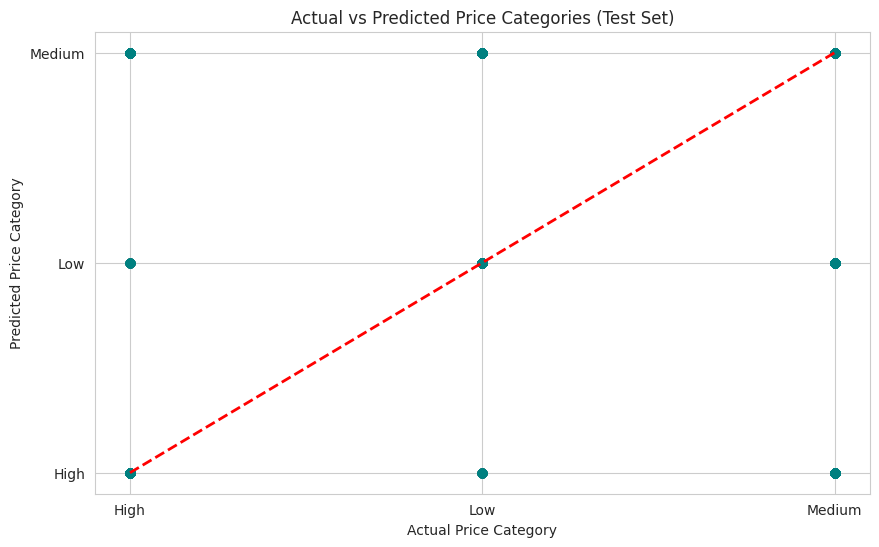

In [ ]:
# Actual vs Predicted Price
plt.figure(figsize=(10, 6))
plt.scatter(y_test_cls, y_pred_cls, alpha=0.6, color='teal')
plt.plot([0, 2], [0, 2], 'r--', lw=2)
plt.xlabel('Actual Price Category')
plt.ylabel('Predicted Price Category')
plt.title('Actual vs Predicted Price Categories (Test Set)')
plt.xticks([0, 1, 2], label_encoder_target_cls.classes_)
plt.yticks([0, 1, 2], label_encoder_target_cls.classes_)
plt.grid(True)
plt.show()

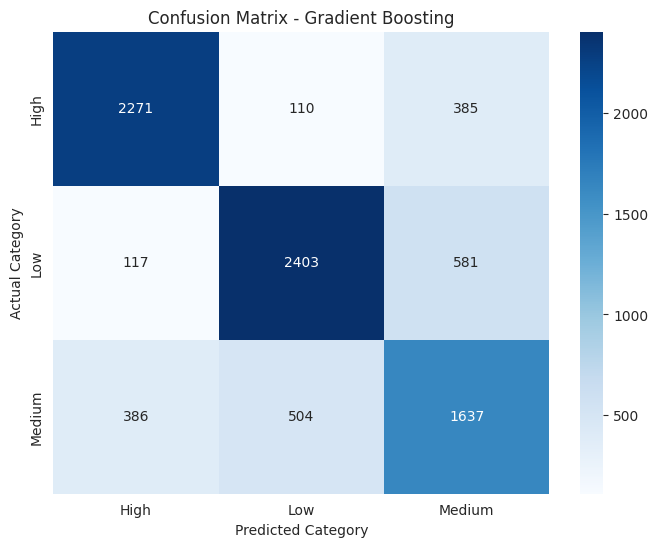

In [ ]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_target_cls.classes_, yticklabels=label_encoder_target_cls.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()


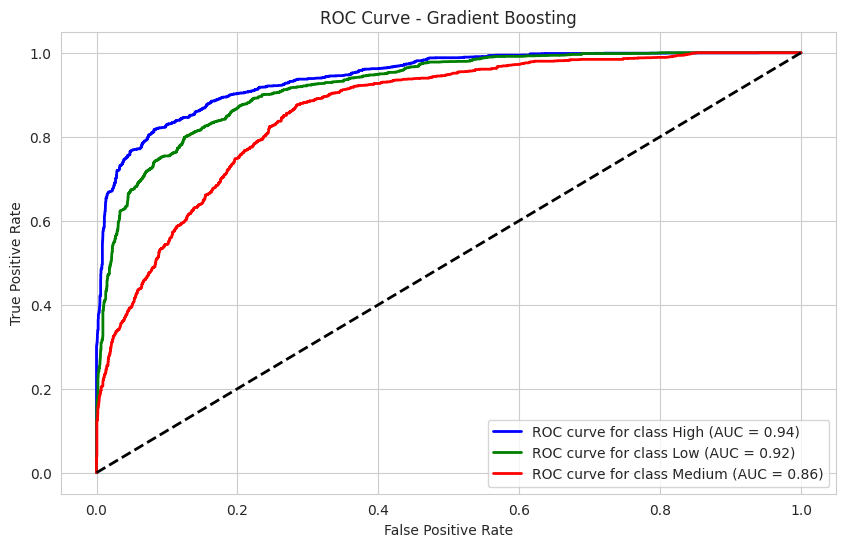

In [ ]:
# ROC Curve
y_score = gb_cls.predict_proba(X_test_cls_scaled)
n_classes = len(label_encoder_target_cls.classes_)
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cls == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {label_encoder_target_cls.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **Comparision between the two models used**

In [ ]:
# Metrics for RandomForestRegressor (regression)
rf_metrics = {
    'Model': 'RandomForestRegressor',
    'MAE': mean_absolute_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R²': r2_score(y_test, y_pred),
    'Accuracy': None
}

# Metrics for GradientBoostingClassifier (classification)
gb_metrics = {
    'Model': 'GradientBoostingClassifier',
    'MAE': mean_absolute_error(y_test_cls, y_pred_cls),
    'MSE': mean_squared_error(y_test_cls, y_pred_cls),
    'RMSE': np.sqrt(mean_squared_error(y_test_cls, y_pred_cls)),
    'R²': None,
    'Accuracy': accuracy_score(y_test_cls, y_pred_cls)
}

# Combine metrics
results_df = pd.DataFrame([rf_metrics, gb_metrics])

# Print results table
print("\nModel Comparison Results:")
print(results_df.to_string(index=False))


Model Comparison Results:
                     Model      MAE        MSE      RMSE       R²  Accuracy
     RandomForestRegressor 6.134080 137.445141 11.723700 0.975813       NaN
GradientBoostingClassifier 0.340005   0.523707  0.723676      NaN  0.751847


/tmp/ipython-input-41-884825229.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, ax=axes[i], palette='Set2')
/tmp/ipython-input-41-884825229.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, ax=axes[i], palette='Set2')
/tmp/ipython-input-41-884825229.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, ax=axes[i], palette='Set2')


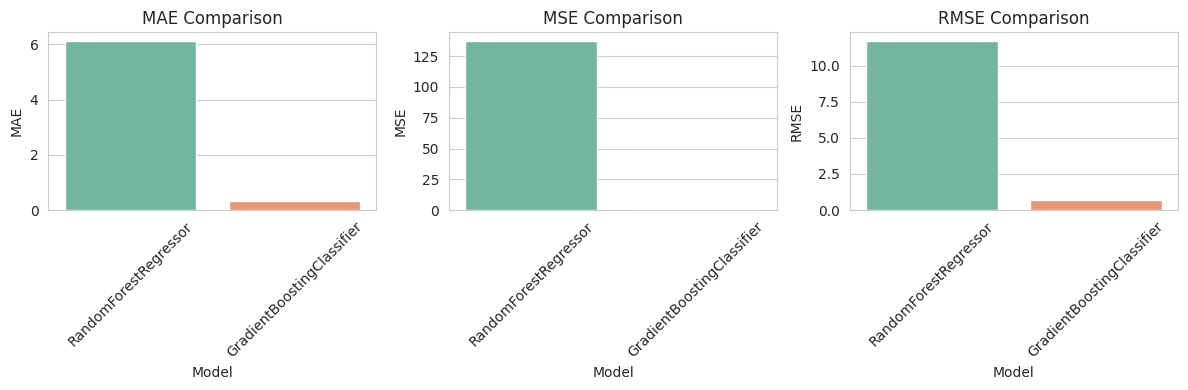

In [ ]:
# Bar plots for shared metrics
metrics_to_plot = ['MAE', 'MSE', 'RMSE']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x='Model', y=metric, data=results_df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()